CS441 Final Project Random Forest Part

Load the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

datadir = "/content/drive/My Drive/CS441/Final Project/"
csv_path = datadir + "T_ONTIME_REPORTING.csv"

Mounted at /content/drive


In [2]:
import pandas as pd
import os

def load_flight_data(path):
  if not os.path.isfile(path):
    raise FileNotFoundError(f"CSV not found at: {path}")
  df = pd.read_csv(path, low_memory=False)
  print(f"Loaded {len(df):,} rows")
  return df

df = load_flight_data(csv_path)
df.head()

# check if file is loaded
print(df.shape)
df.head()


Loaded 539,747 rows
(539747, 24)


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,...,DEP_DEL15,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,733.0,-21.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,832.0,-17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,1052.0,-22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,1300.0,-23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2025,1,1,1,3,1/1/2025 12:00:00 AM,AA,AA,ABQ,"Albuquerque, NM",...,0.0,2005.0,17.0,0.0,NaN,7.0,0.0,10.0,0.0,0.0


In [3]:
df = df.dropna(subset=['ARR_DELAY']) # remove rows with missing delay
df = df[(df['ORIGIN'] == 'ORD') | (df['DEST'] == 'ORD')]  # keep only flights to/from ORD
df['Delayed'] = (df['ARR_DELAY'] > 15).astype(int)

# input features
features = df[['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME']].copy()
y = df['Delayed']

# convert time to hours
features['DEP_HOUR'] = (features['DEP_TIME'] // 100).astype(int)
features = features.drop(columns=['DEP_TIME'])

# a quick check
features.head()



,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_HOUR
5,AA,ABQ,ORD,13
27,AA,ATL,ORD,7
54,AA,AUS,ORD,5
71,AA,BDL,ORD,7
121,AA,BOS,ORD,6


Split into training data and validation data

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  features, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((33914, 4), (8479, 4))

Convert strings into numeric value, so it works with random forest

In [5]:
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(
  transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
  ],
  remainder='passthrough'
)


Train the model

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        random_state=42
    ))
])

model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OP_UNIQUE_CARRIER',
                                                   'ORIGIN', 'DEST'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Validation

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


val_accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", val_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Validation Accuracy: 0.839603726854582

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.91      6812
           1       0.69      0.33      0.45      1667

    accuracy                           0.84      8479
   macro avg       0.77      0.65      0.68      8479
weighted avg       0.82      0.84      0.82      8479


Confusion Matrix:
[[6568  244]
 [1116  551]]


Graphical results

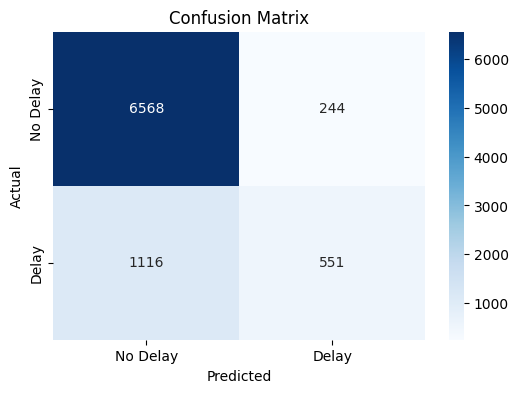

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Delay", "Delay"],
            yticklabels=["No Delay", "Delay"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
